In [61]:
from groundedPL.codificacion import ToPropositionalLogic
from groundedPL.logic_tester import LogicTester
import sys

parser = ToPropositionalLogic()
sys.setrecursionlimit(10**6)

In [62]:
from itertools import product
import random

#triplas = product(range(5), range(5), range(4))
triplas = product(range(8), range(8), range(4))

for x, y, n in triplas:
    parser.parse(f'En({x}, {y}, {n})')

In [63]:
from groundedPL.logUtils import LogUtils
from typing import List, Tuple
NUM_FILAS = 8
NUM_COLUMNAS = 8


def barco_h(x: int, y: int, n: int) -> List[List[Tuple[int, int]]]:
    """
    Genera todos los barcos horizontales de tamaño `n` que pasan por (x, y).
    
    Parámetros:
        x, y: Coordenadas de la casilla (0-7)
        n: Tamaño del barco (1-4)
    
    Retorna:
        Lista de barcos, donde cada barco es una lista de tuplas (fila, columna)
    """
    if not (0 <= x < NUM_FILAS and 0 <= y < NUM_COLUMNAS):
        return []
    if not (1 <= n <= 4):
        return []
    barcos = []
    # Rango de posibles posiciones iniciales horizontales
    inicio_min = max(0, x - n + 1)
    inicio_max = x
    
    for inicio_x in range(inicio_min, inicio_max + 1):
        casillas = [(inicio_x + i, y) for i in range(n)]
        # Verificar que todas las casillas estén dentro del tablero
        if all(0 <= cx < NUM_FILAS for cx, _ in casillas):
            barcos.append(casillas)
    
    return barcos


def barco_v(x: int, y: int, n: int) -> List[List[Tuple[int, int]]]:
    """
    Genera todos los barcos verticales de tamaño `n` que pasan por (x, y).
    
    Parámetros:
        x, y: Coordenadas de la casilla (0-7)
        n: Tamaño del barco (1-4)
    
    Retorna:
        Lista de barcos, donde cada barco es una lista de tuplas (fila, columna)
    """
    if not (0 <= x < NUM_FILAS and 0 <= y < NUM_COLUMNAS):
        return []
    if not (1 <= n <= 4):
        return []
    barcos = []
    # Rango de posibles posiciones iniciales verticales
    inicio_min = max(0, y - n + 1)
    inicio_max = y
    
    for inicio_y in range(inicio_min, inicio_max + 1):
        casillas = [(x, inicio_y + j) for j in range(n)]
        # Verificar que todas las casillas estén dentro del tablero
        if all(0 <= cy < NUM_COLUMNAS for _, cy in casillas):
            barcos.append(casillas)
    
    return barcos

# Regla general: Barcos alineados horizontal o verticalmente Y todas las casillas entre inicio y fin de un barco deben estar ocupadas
def regla_general():
    condiciones = []
    for x in range(NUM_FILAS):
        for y in range(NUM_COLUMNAS):
            for n in range(1, 5):
                # Generar todas las configuraciones válidas de barcos que pasan por (x,y)
                configuraciones = []
                
                # Barcos horizontales
                for barco in barco_h(x, y, n):
                    # Construir conjunción: todas las casillas del barco + negaciones externas
                    clausulas = []
                    for (u, v) in barco:
                        clausulas.append(f"En({u},{v},{n})")
                        # clausulas.append(parser.to_nltk(f"En({u},{v},{n})"))
                    for r in range(NUM_FILAS):
                        for s in range(NUM_COLUMNAS):
                            if (r, s) not in barco:
                                clausulas.append(f"-En({r},{s},{n})")
                                # clausulas.append(parser.to_nltk(f"-En({r},{s},{n})"))
                    configuraciones.append(LogUtils.Ytoria_str(clausulas))
                    # configuraciones.append(LogUtils.Ytoria(clausulas))
                
                # Barcos verticales
                for barco in barco_v(x, y, n):
                    clausulas = []
                    for (u, v) in barco:
                        # clausulas.append(parser.to_nltk(f"En({u},{v},{n})"))
                        clausulas.append(f"En({u},{v},{n})")
                    for r in range(NUM_FILAS):
                        for s in range(NUM_COLUMNAS):
                            if (r, s) not in barco:
                            #    clausulas.append(parser.to_nltk(f"-En({r},{s},{n})"))
                               clausulas.append(f"-En({r},{s},{n})")
                                               
                # Construir la implicación manualmente
                if configuraciones:
                    antecedente = f"En({x},{y},{n})"
                    # antecedente = parser.to_nltk(f"En({x},{y},{n})")
                    consecuente = LogUtils.Otoria_str(configuraciones)
                    implicacion = f"({antecedente} -> {consecuente})"
                    #implicacion = f"(({antecedente} -> ({consecuente})) & (({consecuente}) -> {antecedente}))"
                    condiciones.append(implicacion)
                    # condiciones.append(parser.to_nltk(implicacion))
    
    # return LogUtils.Ytoria(condiciones)
    return LogUtils.Ytoria_str(condiciones)

# Regla 4: No superposición de barcos
def crear_regla_4():
    condiciones = []
    for x in range(NUM_FILAS):
        for y in range(NUM_COLUMNAS):
            for n in range(1, 5):
                negaciones = []
                for m in range(1, 5):
                    if m != n:
                        negaciones.append(f"-En({x},{y},{m})")
                        # negaciones.append(parser.to_nltk(f"-En({x},{y},{m})"))
                antecedente = f"En({x},{y},{n})"    
                consecuente = LogUtils.Ytoria_str(negaciones)
                # consecuente = LogUtils.Ytoria(negaciones)
                implicacion = f"({antecedente} -> {consecuente})"
                condiciones.append(implicacion)
                # condiciones.append(parser.to_nltk(implicacion))
    return LogUtils.Ytoria_str(condiciones)
    # return LogUtils.Ytoria(condiciones)


# Opcion A: Crear una regla del tablero donde le paso la interpretacion que tenga mi informacion parcial 
# Opcion B: Es darle manualmente la informacion de todo el tablero 

barcos = [(0,0,1),(5,2,2),(2,6,3),(2,2,4)]

def regla_tablero_en():
    literales = []
    for x, y, n in barcos:
        literales.append(f"En({x},{y},{n})")
    print("Barcos en tablero")
    for x, y, n in barcos:
        print(f"Barco de tamaño {n} en ({x}, {y})")
    return LogUtils.Ytoria_str(literales)

def reglas():
    r = []
    r.append(regla_general())

    r.append(crear_regla_4())

    r.append(regla_tablero_en())
    
    return LogUtils.Ytoria_str(r)





---

In [64]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def visualizar_batalla_naval(I: dict):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xlim(-0.5, NUM_COLUMNAS-0.5)
    ax.set_ylim(-0.5, NUM_FILAS-0.5)
    ax.set_xticks(range(NUM_COLUMNAS))
    ax.set_yticks(range(NUM_FILAS))
    ax.grid(True,linewidth=0.0)
    ax.invert_yaxis()

    colores = {
        'destapada': '#2196F3',  
        'tapada': "#FFFFFF",     
        'barco': "#720E0E"      
    }

    for x in range(NUM_FILAS):
        for y in range(NUM_COLUMNAS):
            rect = patches.Rectangle(
                (y-.5, x-0.5), 1, 1,
                facecolor=colores['tapada'],
                edgecolor='black',
                linewidth=0.5
            )
            ax.add_patch(rect)
            
    for letra, value in I.items():
        if value:
            x, y, n = parser.obtener_argumentos(letra)
            x, y, n = int(x), int(y), int(n)
            # Fondo azul para casilla destapada
            destapada_rect = patches.Rectangle(
                (y - 0.5, x - 0.5), 1, 1,
                facecolor=colores['destapada'],
                edgecolor='black',
                linewidth=0.5,
                zorder=1
            )
            ax.add_patch(destapada_rect)

    for letra, value in I.items():
        if value:
            x, y, n = parser.obtener_argumentos(letra)
            x, y, n = int(x), int(y), int(n)
            barco_rect = patches.Rectangle(
                (y - 0.5 + 0.15, x - 0.5 + 0.15), 0.7, 0.7,
                facecolor=colores['barco'],
                edgecolor='black',
                linewidth=1.0,
                zorder=2
            )
            ax.add_patch(barco_rect)
            ax.text(
                y, x, str(n),
                ha='center', va='center',
                color='white', fontsize=12,
                weight='bold',
                zorder=3
            )

    plt.title("Batalla Naval - Modo Parcial")
    plt.show()

In [65]:
print(barcos)

[(0, 0, 1), (5, 2, 2), (2, 6, 3), (2, 2, 4)]


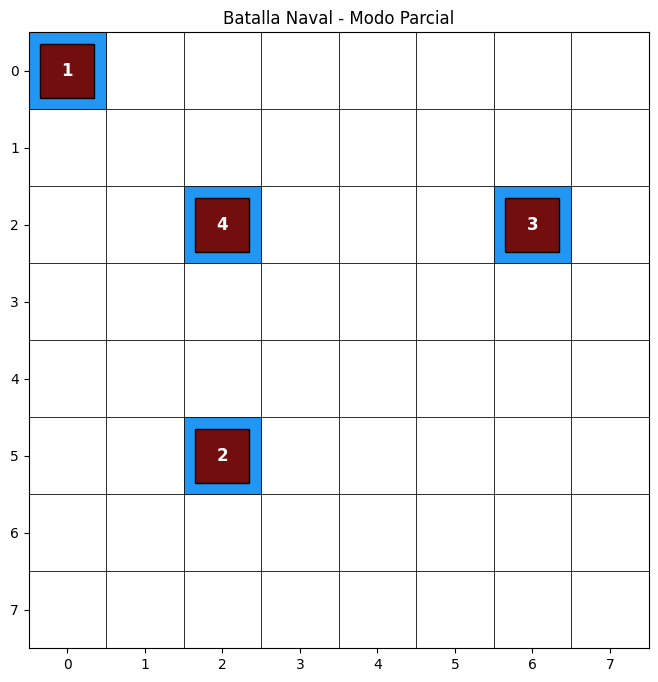

In [66]:
#Visualizacion del batalla naval sin completar
def barcos_a_dict(barcos):
    return {parser.parse(f"En({x},{y},{n})"): True for x, y, n in barcos}
visualizar_batalla_naval(barcos_a_dict(barcos))

Barcos en tablero
Barco de tamaño 1 en (0, 0)
Barco de tamaño 2 en (5, 2)
Barco de tamaño 3 en (2, 6)
Barco de tamaño 4 en (2, 2)


  0%|          | 0/158141 [01:02<?, ?it/s]


La fórmula es satisfacible


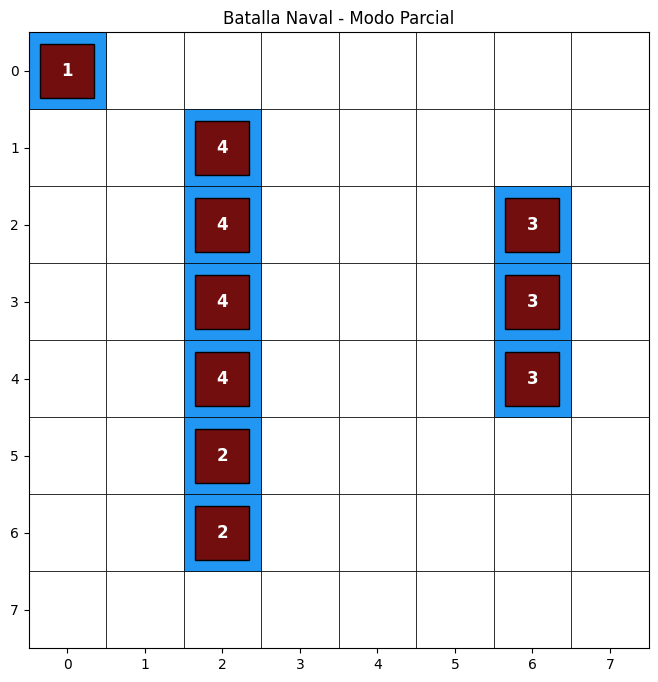

In [67]:
lt = LogicTester()
regla = reglas()
formula_lp = lt.translation_to_prover(regla)
res = lt.SATsolve(formula_lp)

#print("SAT resultado:", res)
#print("Formula: ", formula_lp)
if res == 'UNSAT':
    print('La fórmula es insatisfacible')
else:
    print('La fórmula es satisfacible')
    
    modelo = [lt.to_numeric.literal(x) for x in res]
    modelo = [x for x in modelo if lt.to_numeric.solo_atomo(x) in lt.tseitin.atomos]
    #print(f'\nModelo:\n\n\t{modelo}')

    modelo_decodificado = [lt.to_lp.modelo_lp.decodificar(x) for x in modelo]
    #print(f'\nModelo decodificado:\n\n\t{modelo_decodificado}')


    condicion_inicial = parser.crear_interpretacion(modelo_decodificado)
    visualizar_batalla_naval(condicion_inicial)

